## Report Structure Note

This Jupyter/Colab notebook is written in report style and integrates code, results,
and interpretation in line with the assignment brief. Section headings correspond
directly to Parts A-F of the assessment criteria.


Colab link: https://colab.research.google.com/drive/1J8t4QfuzL5KegelcbtmqpY_1rgecMrIz#scrollTo=HoJVrCmxL2x3



Github Link https://github.com/Penny-Coe/graphs-networks-assignment/tree/main

# <font color=#DAA520><b> DSC5005M Graphs, Networks & Systems Assignment   </font>

#  <font color=#bc5a45><b> A) Introduction:

##  <font color=#bc5a45><b> A) 1. The problem

The growth of digital media platforms has made it increasingly difficult for users to discover movies that align with their personal preferences. With thousands of films available, users often experience information overload, leading to poor decision-making driven by generic recommendations or random browsing. This highlights the need for systems that explicitly model relationships between movies, as recommendation quality depends on relational structure rather than independent item attributes.

The IMDB-5000 Movie Dataset provides information on genres, directors, actors, keywords, budgets, and audience-ratings, making it well-suited for modelling similarity relationships between films. Because these attributes naturally describe how movies relate to one another, the dataset provides an appropriate foundation for exploring relational approaches to movie recommendation

##  <font color=#bc5a45><b> A) 2. Network-Based Solution

A network system addresses the movie recommendation problem by representing movies as nodes within a similarity graph, where edges connect films that share meaningful attributes such as common genres or cast members. These connections form a movie similarity network in which closely related films occupy densely connected neighbourhoods. Recommendations can then be generated by selecting a user’s preferred film and identifying nearby nodes within the same neighbourhood.

The graph can be further enriched by assigning weights to edges based on the number or importance of shared attributes, strengthening the representation of similarity. Where appropriate, edge direction can be used to capture temporal ordering between older and newer films. Applying network analysis techniques such as similarity measures, centrality analysis, and community detection then reveals influential movies and clusters of related films, directly supporting a personalised, network-driven recommendation system. *(Barabási, 2016; Newman, 2010)*

#  <font color=#bc5a45><b> Appendix 1: Data Environment setup

##  <font color=#bc5a45><b> Appendix 1.1 Importing the dataset

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("carolzhangdc/imdb-5000-movie-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'imdb-5000-movie-dataset' dataset.
Path to dataset files: /kaggle/input/imdb-5000-movie-dataset


##  <font color=#bc5a45><b> Appendix 1.2 Importing the libraries

In [ ]:
import os
import pandas as pd
import networkx as nx
from itertools import combinations
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import random
from networkx.algorithms.community import greedy_modularity_communities
random.seed(42)
np.random.seed(42)
import ast

#  <font color=#bc5a45><b> Appendix 2: Dataset Preparation

##  <font color=#bc5a45><b> Appendix 2.1 Data Investigation

The IMDB-5000 dataset was inspected to understand its structure and available attributes. It contains approximately 5,000 movie records with metadata including genres, actors, keywords, budget, gross revenue, and audience ratings. *(Zhang, 2016)*

Pre-processing was required prior to network construction due to multi-valued attributes and missing data.

In [ ]:
os.listdir(path)

['movie_metadata.csv']

In [ ]:
df = pd.read_csv(f"{path}/movie_metadata.csv")
df.shape

(5043, 28)

In [ ]:
df.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


In [ ]:
df.info ()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   color                      5024 non-null   object 
 1   director_name              4939 non-null   object 
 2   num_critic_for_reviews     4993 non-null   float64
 3   duration                   5028 non-null   float64
 4   director_facebook_likes    4939 non-null   float64
 5   actor_3_facebook_likes     5020 non-null   float64
 6   actor_2_name               5030 non-null   object 
 7   actor_1_facebook_likes     5036 non-null   float64
 8   gross                      4159 non-null   float64
 9   genres                     5043 non-null   object 
 10  actor_1_name               5036 non-null   object 
 11  movie_title                5043 non-null   object 
 12  num_voted_users            5043 non-null   int64  
 13  cast_total_facebook_likes  5043 non-null   int64


##  <font color=#bc5a45><b> Appendix 2.2 Attribute selection

The attributes listed in the table were selected either to define similarity relationships between movies (e.g. cast and genre) or to provide contextual information for interpreting network structure and communities (e.g. rating, release year, and country). A refined dataframe was constructed using these attributes.

| Attribute Name | Description | Role in Network Analysis |
|---------------|------------|--------------------------|
| movie_title | Title of the movie | Used as the node identifier for each movie |
| director_name | Name of the movie’s director | Creates edges between movies with the same director |
| actor_1_name | Lead actor | Creates similarity edges based on shared cast members |
| actor_2_name | Supporting actor | Strengthens similarity relationships |
| actor_3_name | Supporting actor | Strengthens similarity relationships |
| genres | Movie genres (pipe-separated) | Creates edges between movies of the same genre |
| plot_keywords | Keywords describing the plot | Provides thematic context |
| imdb_score | IMDb user rating | Interprets influential or central movies |
| title_year | Year of release | Supports temporal analysis |
| country | Country of production | Provides contextual insight |

In [ ]:
# Working copy
movies = df.copy()

# Keep only columns we actually care about for the network
movies = movies[[
    'movie_title',
    'director_name',
    'actor_1_name', 'actor_2_name', 'actor_3_name',
    'genres',
    'plot_keywords',
    'imdb_score',
    'title_year',
    'country'
]]

movies.head()

,movie_title,director_name,actor_1_name,actor_2_name,actor_3_name,genres,plot_keywords,imdb_score,title_year,country
0,Avatar,James Cameron,CCH Pounder,Joel David Moore,Wes Studi,Action|Adventure|Fantasy|Sci-Fi,avatar|future|marine|native|paraplegic,7.9,2009.0,USA
1,Pirates of the Caribbean: At World's End,Gore Verbinski,Johnny Depp,Orlando Bloom,Jack Davenport,Action|Adventure|Fantasy,goddess|marriage ceremony|marriage proposal|pi...,7.1,2007.0,USA
2,Spectre,Sam Mendes,Christoph Waltz,Rory Kinnear,Stephanie Sigman,Action|Adventure|Thriller,bomb|espionage|sequel|spy|terrorist,6.8,2015.0,UK
3,The Dark Knight Rises,Christopher Nolan,Tom Hardy,Christian Bale,Joseph Gordon-Levitt,Action|Thriller,deception|imprisonment|lawlessness|police offi...,8.5,2012.0,USA
4,Star Wars: Episode VII - The Force Awakens ...,Doug Walker,Doug Walker,Rob Walker,NaN,Documentary,NaN,7.1,NaN,NaN


##  <font color=#bc5a45><b> Appendix 2.3 Data cleaning


Text-based attributes were cleaned to remove inconsistent formatting and missing values that could otherwise create duplicate nodes or spurious edges.

In [ ]:
# Columns to treat as text
text_cols = [
    'movie_title',
    'director_name',
    'actor_1_name', 'actor_2_name', 'actor_3_name',
    'genres',
    'plot_keywords',
    'country'
]

for col in text_cols:
    movies[col] = movies[col].astype(str).str.replace(r'\xa0', '', regex=True).str.strip()


Movies lacking essential information (title or genre) were removed to ensure meaningful similarity-based connections.

In [ ]:
# Drop rows with missing title or genres
movies = movies.replace({'nan': None})  # convert 'nan' strings back to real NaNs
movies = movies.dropna(subset=['movie_title', 'genres'])

# Drop movies where ALL three actors are missing
movies = movies[
    movies[['actor_1_name', 'actor_2_name', 'actor_3_name']].notna().any(axis=1)
]

print("Remaining rows:", len(movies))

Remaining rows: 5036


Genre and plot-keyword fields were converted into list formats to support efficient similarity comparisons and interpretation

In [ ]:
movies['genre_list'] = movies['genres'].apply(lambda x: [g.strip() for g in x.split('|') if g.strip() != ''])
movies[['movie_title', 'genre_list']].head()

,movie_title,genre_list
0,Avatar,"[Action, Adventure, Fantasy, Sci-Fi]"
1,Pirates of the Caribbean: At World's End,"[Action, Adventure, Fantasy]"
2,Spectre,"[Action, Adventure, Thriller]"
3,The Dark Knight Rises,"[Action, Thriller]"
4,Star Wars: Episode VII - The Force Awakens,[Documentary]


In [ ]:
# Replace NaN with empty string first
movies['plot_keywords'] = movies['plot_keywords'].fillna('')

movies['keyword_list'] = movies['plot_keywords'].apply(
    lambda x: [k.strip() for k in x.split('|') if k.strip() != '']
)

movies[['movie_title', 'keyword_list']].head()

,movie_title,keyword_list
0,Avatar,"[avatar, future, marine, native, paraplegic]"
1,Pirates of the Caribbean: At World's End,"[goddess, marriage ceremony, marriage proposal..."
2,Spectre,"[bomb, espionage, sequel, spy, terrorist]"
3,The Dark Knight Rises,"[deception, imprisonment, lawlessness, police ..."
4,Star Wars: Episode VII - The Force Awakens,[]


Checks confirmed the number of remaining movies and the correct structure of cleaned attributes prior to graph construction.

In [ ]:
print("Number of movies:", movies['movie_title'].nunique())
print("Example row:")
movies.iloc[0]

Number of movies: 4909
Example row:


,0
movie_title,Avatar
director_name,James Cameron
actor_1_name,CCH Pounder
actor_2_name,Joel David Moore
actor_3_name,Wes Studi
genres,Action|Adventure|Fantasy|Sci-Fi
plot_keywords,avatar|future|marine|native|paraplegic
imdb_score,7.9
title_year,2009.0
country,USA


#  <font color=#bc5a45><b> Appendix 3: Network Construction




Network construction and analysis were implemented using the NetworkX Python library *(Hagberg et al., 2008)*.

##  <font color=#bc5a45><b> Appendix 3.1 Graph Initialisation and Node Creation

Each movie was represented as a node in a directed graph, with edge direction encoding temporal ordering from earlier to later releases. Same-year films were linked bidirectionally to represent mutual similarity. Relevant metadata were stored as node attributes.

In [ ]:
DG = nx.DiGraph()

for _, row in movies.iterrows():
    movie_id = row['movie_title']

    DG.add_node(
        movie_id,
        director=row['director_name'],
        actors=[a for a in [row['actor_1_name'], row['actor_2_name'], row['actor_3_name']] if a],
        genres=row['genre_list'],
        keywords=row['keyword_list'],
        imdb_score=row['imdb_score'],
        year=row['title_year'],
        country=row['country']
    )

print("Number of nodes (movies):", DG.number_of_nodes())

Number of nodes (movies): 4909


##  <font color=#bc5a45><b> Appendix 3.2 Creating egde's


###  <font color=#bc5a45><b> Appendix 3.2.1 Edges for shared actors

Actor-to-movies mapping was constructed to identify films that share the same actor.

In [ ]:
actor_cols = ['actor_1_name', 'actor_2_name', 'actor_3_name']
# Creates a dictionary where keys = actor names and values = list of movies they appear in.
actor_to_movies = defaultdict(list)
# Loop through each movie (each row in the dataset)
for _, row in movies.iterrows():
# Decide how this movie is identified in the graph
    movie_id = row['movie_title']  # must match node IDs in G
# Collect the actors for this movie
    actors = {row[c] for c in actor_cols if row[c]}  # avoids '' and NaN
# Update the actor/movie mapping
    for actor in actors:
        actor_to_movies[actor].append(movie_id)

Directed edges were added between pairs of movies that share one or more actor. Where an edge already existed due to actor similarity, the edge weight was increased to reflect combined similarity. This step created 46,131 edges.

In [ ]:
# Loop over each actor and the list of movies they appear in
for actor, movie_ids in actor_to_movies.items():

    # An actor must appear in at least 2 movies to create a link
    if len(movie_ids) < 2:
        continue

    # Consider all unique movie pairs for this actor
    for m1, m2 in combinations(movie_ids, 2):

        # Retrieve release years from node attributes
        y1 = DG.nodes[m1].get("year", np.nan)
        y2 = DG.nodes[m2].get("year", np.nan)

        # Skip if either movie has missing year data
        if pd.isna(y1) or pd.isna(y2):
            continue

        y1 = int(y1)
        y2 = int(y2)


        # Decide edge direction
        if y1 == y2:
            # Same-year movies:
            # add edges both ways to represent mutual similarity
            pairs = [(m1, m2), (m2, m1)]
        else:
            # Different years:
            # enforce temporal direction (older → newer)
            src, dst = (m1, m2) if y1 < y2 else (m2, m1)
            pairs = [(src, dst)]

        # Add or strengthen edges
        for src, dst in pairs:

            if DG.has_edge(src, dst):
                # Edge already exists → strengthen it
                DG[src][dst]['weight'] += 1
                DG[src][dst].setdefault('shared_actors', set()).add(actor)
                DG[src][dst].setdefault('shared_genres', set())

            else:
                # Create a new directed edge
                DG.add_edge(
                    src, dst,
                    weight=1,
                    shared_actors={actor},
                    shared_genres=set()
                )

print("Edges after actor linking:", DG.number_of_edges())


Edges after actor linking: 46131


###  <font color=#bc5a45><b> Appendix 3.2.2 Edges for shared genres

Genre-to-movies mapping was constructed to identify films that share the same genre prior to edge creation.

In [ ]:
# Create a mapping from each genre to the list of movies that belong to it
genre_to_movies = defaultdict(list)

# Loop through each movie in the dataset
for _, row in movies.iterrows():
    movie_id = row['movie_title']  # unique identifier for the movie node in the graph

    # Loop through all genres associated with this movie
    for g in row['genre_list']:
        if g:  # ignore empty or invalid genre entries
            # Add this movie to the list of movies for the given genre
            genre_to_movies[g].append(movie_id)

Directed edges were created between pairs of movies that share at least one genre. Each shared genre contributes to the edge weight, allowing stronger similarity relationships to be represented by higher-weight edges. This created 6,596,317 edges

In [ ]:
# Loop through each genre and the list of movies associated with it
for genre, movie_ids in genre_to_movies.items():

    # A genre must appear in at least 2 movies to create links
    if len(movie_ids) < 2:
        continue

    # Generate all unique movie pairs sharing this genre
    for m1, m2 in combinations(movie_ids, 2):

        # Retrieve release years
        y1 = DG.nodes[m1].get("year", np.nan)
        y2 = DG.nodes[m2].get("year", np.nan)

        # Skip pairs with missing year information
        if pd.isna(y1) or pd.isna(y2):
            continue

        y1 = int(y1)
        y2 = int(y2)


        # Decide edge direction(s)
        if y1 == y2:
        # Same-year movies have bidirectional edges
            pairs = [(m1, m2), (m2, m1)]
        else:
        # Enforce temporal ordering
            src, dst = (m1, m2) if y1 < y2 else (m2, m1)
            pairs = [(src, dst)]

        # Add or strengthen edges
        for src, dst in pairs:

            if DG.has_edge(src, dst):
                # Strengthen existing edge
                DG[src][dst]['weight'] += 1
                DG[src][dst].setdefault('shared_genres', set()).add(genre)
                DG[src][dst].setdefault('shared_actors', set())

            else:
          # Create new directed edge
                DG.add_edge(
                    src, dst,
                    weight=1,
                    shared_actors=set(),
                    shared_genres={genre}
                )

print("Total number of edges after genre linking:", DG.number_of_edges())

Total number of edges after genre linking: 6596317


To limit combinatorial explosion from broad similarity criteria, a minimum edge-weight threshold was applied post-construction, retaining only stronger multi-feature similarities. This reduced the network to 400,402 edges with low density (≈1.7%), indicating a sparse and selective similarity structure.

In [ ]:
MIN_WEIGHT = 3

to_remove = [(u, v) for u, v, d in DG.edges(data=True) if d.get("weight", 0) < MIN_WEIGHT]
DG.remove_edges_from(to_remove)

print("Edges after threshold:", DG.number_of_edges())
print("Density:", nx.density(DG))

Edges after threshold: 400402
Density: 0.016618761375535147


#  <font color=#bc5a45><b> B. Basic Network Properties

##  <font color=#bc5a45><b> B) 1. Number of nodes and edges

After applying a minimum edge-weight threshold the resulting directed network contains 4,909 nodes, representing individual movies, and 400,402 edges, representing temporally ordered similarity links based on shared actors and genres.

In [ ]:
# Basic network size statistics
num_nodes = DG.number_of_nodes()
num_edges = DG.number_of_edges()

print("Number of nodes (movies):", num_nodes)
print("Number of edges (similarity links):", num_edges)

Number of nodes (movies): 4909
Number of edges (similarity links): 400402


##  <font color=#bc5a45><b> B) 2. Average degree and maximum degree.

The average total unweighted degree is approximately 163, indicating that each movie is connected to many others through temporally ordered similarity based on shared actors and genres. This reflects widespread reuse of genres and cast members across the dataset. The maximum degree of 3,976 identifies a highly connected hub movie, suggesting broad similarity driven by common genres or collaborations rather than popularity.

Because the network is directed, degree here represents the sum of in-degree and out-degree, capturing both how many earlier films a movie is similar to and how many later films it connects to.

In [ ]:
degrees = [deg for _, deg in DG.degree()]
avg_degree = np.mean(degrees)
max_degree = np.max(degrees)

print("Average degree:", avg_degree)
print("Maximum degree:", max_degree)

Average degree: 163.129761662253
Maximum degree: 3976


##  <font color=#bc5a45><b> B) 3. Degree distribution.

The right-skewed degree distribution ilustrated in the figure below demonstrates that most movies share similarity to relatively few films, while a small number act as highly connected hubs due to broad genre coverage or recurring cast members. This indicates a heterogeneous network in which connectivity reflects shared attributes rather than popularity or quality.

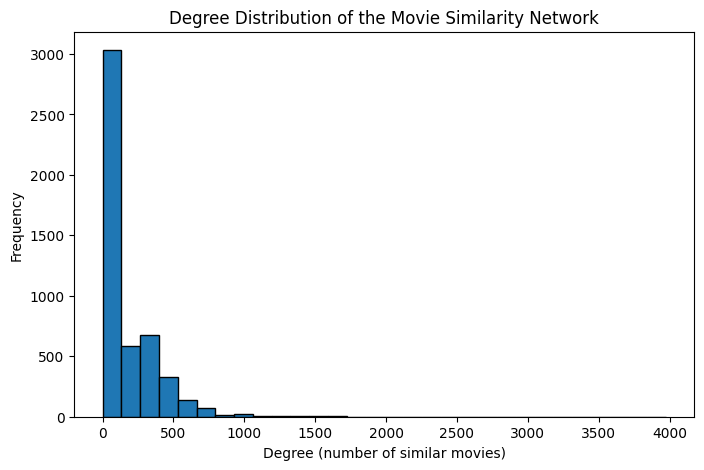

In [ ]:
plt.figure(figsize=(8,5))
plt.hist(degrees, bins=30, edgecolor='black')
plt.title("Degree Distribution of the Movie Similarity Network")
plt.xlabel("Degree (number of similar movies)")
plt.ylabel("Frequency")
plt.show()

##  <font color=#bc5a45><b> B) 4. Largest weakly and strongly connected components

When edge direction is ignored (weak connectivity), the network contains 186 weakly connected components, with the largest comprising 4,721 of the 4,909 movies. This indicates that almost all films are connected through shared genres and cast members.

When temporal direction is enforced (strong connectivity), the network fragments into 1,972 strongly connected components, with the largest containing only 200 movies. This substantial reduction in component size shows that while similarity links are widespread, temporal ordering strongly constrains mutual reachability, partitioning the network into smaller, temporally coherent clusters. Together, the weakly and strongly connected component analysis demonstrates how imposing direction transforms a globally connected similarity network into many smaller, directionally constrained substructures. *(Newman, 2010)*

In [ ]:
# Weakly Connected Components (ignores direction)
wccs = list(nx.weakly_connected_components(DG))
largest_wcc = max(wccs, key=len)

print("Number of WCCs:", len(wccs))
print("Largest WCC size:", len(largest_wcc))

DG_largest_wcc = DG.subgraph(largest_wcc).copy()
print("Largest WCC nodes:", DG_largest_wcc.number_of_nodes(),
      "edges:", DG_largest_wcc.number_of_edges())

Number of WCCs: 186
Largest WCC size: 4721
Largest WCC nodes: 4721 edges: 400396


In [ ]:
# Strongly Connected Components (direction matters)
sccs = list(nx.strongly_connected_components(DG))
largest_scc = max(sccs, key=len)

print("Number of SCCs:", len(sccs))
print("Largest SCC size:", len(largest_scc))

DG_largest_scc = DG.subgraph(largest_scc).copy()
print("Largest SCC nodes:", DG_largest_scc.number_of_nodes(),
      "edges:", DG_largest_scc.number_of_edges())

Number of SCCs: 1972
Largest SCC size: 200
Largest SCC nodes: 200 edges: 2130


The figure below shows the largest strongly connected component of the directed movie similarity network (200 movies). Its dense core and directed cycles indicate reciprocal similarity driven by overlapping release years, shared cast, and common genres, while its small size relative to the full network highlights how temporal ordering restricts mutual connectivity.

In [ ]:
# Get all weakly connected components
wccs = list(nx.weakly_connected_components(DG))

# Identify the largest one
largest_wcc = max(wccs, key=len)

# Create a subgraph containing only that component
DG_largest = DG.subgraph(largest_wcc).copy()

print("Largest WCC nodes:", DG_largest.number_of_nodes())
print("Largest WCC edges:", DG_largest.number_of_edges())

Largest WCC nodes: 4721
Largest WCC edges: 400396


SCC size: 200


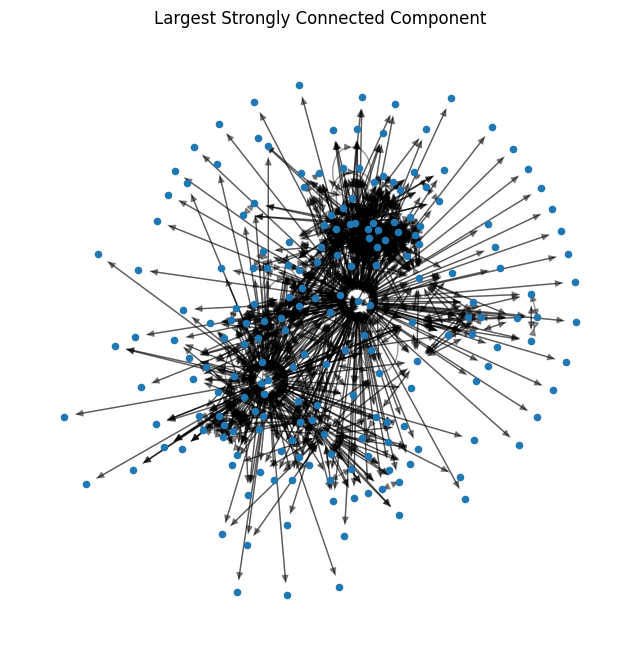

In [ ]:
# Extract the largest SCC
largest_scc = max(nx.strongly_connected_components(DG), key=len)
DG_scc = DG.subgraph(largest_scc).copy()

print("SCC size:", DG_scc.number_of_nodes())

pos = nx.spring_layout(DG_scc, k=0.3, seed=42)

plt.figure(figsize=(8, 8))
nx.draw_networkx_nodes(DG_scc, pos, node_size=20)
nx.draw_networkx_edges(DG_scc, pos, alpha=0.4)
plt.title("Largest Strongly Connected Component")
plt.axis("off")
plt.show()

The figure below shows a random 200-node sample from the largest weakly connected component of the directed movie similarity network. The large, connected core indicates that most movies are linked through shared genres and cast when temporal direction is ignored, while peripheral nodes remain connected via indirect paths. In contrast to the strongly connected component, this illustrates a globally connected similarity structure despite temporal constraints.

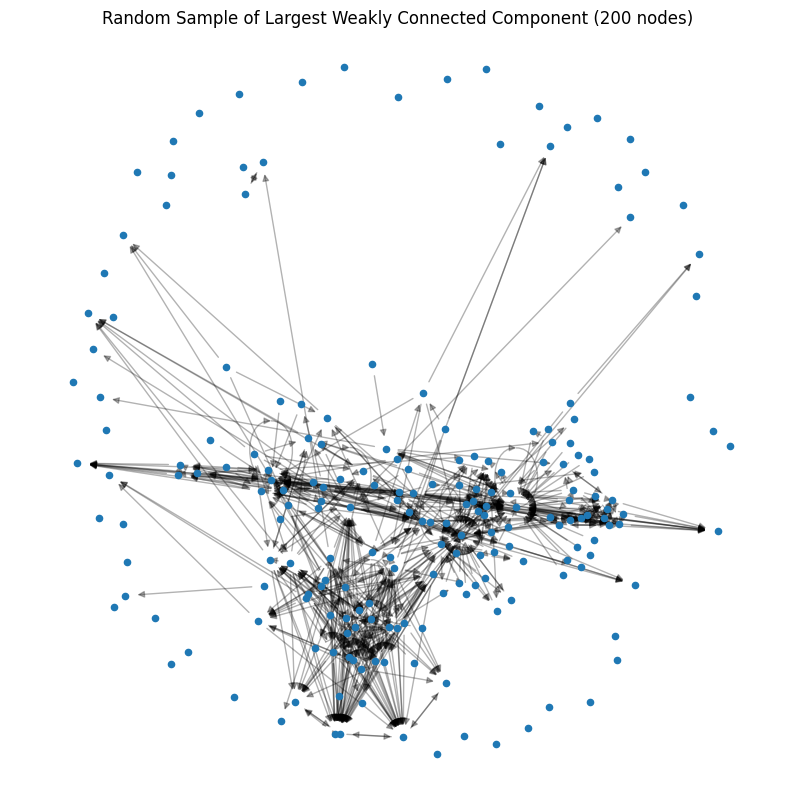

In [ ]:
# Randomly sample 200 nodes from the largest WCC for visualisation
sample_nodes = random.sample(list(DG_largest_wcc.nodes()), 200)

# Create the induced subgraph
DG_vis = DG_largest_wcc.subgraph(sample_nodes).copy()

# Compute layout
pos = nx.spring_layout(DG_vis, k=0.3, seed=42)

# Plot
plt.figure(figsize=(10, 10))
nx.draw_networkx_nodes(DG_vis, pos, node_size=20)
nx.draw_networkx_edges(DG_vis, pos, alpha=0.3)
plt.title("Random Sample of Largest Weakly Connected Component (200 nodes)")
plt.axis("off")
plt.show()

In [ ]:
# Create a small induced subgraph for algorithm demos
# Use largest WCC if you already computed; or use DG directly.
G_demo_base = DG_largest_wcc if 'DG_largest_wcc' in globals() else DG

# Pick a reproducible sample of nodes to keep the demo fast
random.seed(42)
demo_nodes = random.sample(list(G_demo_base.nodes()), k=min(200, G_demo_base.number_of_nodes()))

DG_demo = G_demo_base.subgraph(demo_nodes).copy()

# Ensure a start node is chosen that actually has edges
start = next((n for n in DG_demo.nodes() if DG_demo.out_degree(n) + DG_demo.in_degree(n) > 0), None)

print("Demo subgraph nodes:", DG_demo.number_of_nodes(), "edges:", DG_demo.number_of_edges())
print("Start node:", start)

Demo subgraph nodes: 200 edges: 594
Start node: Dreamcatcher


##  <font color=#bc5a45><b> B) 5. Graph Traversal and shortest paths BFS / DFS / Dijkstra

BFS and DFS explore network structure and reachability, while Dijkstra's algorithm computes shortest paths in weighted graphs

BFS — Breath-first traversal explores layers by level based on edge distance.

In [ ]:
# BFS: Breadth-First Search (directed)
bfs_tree = nx.bfs_tree(DG_demo, source=start)

print("BFS tree nodes reached:", bfs_tree.number_of_nodes())
print("First 15 nodes in BFS order:", list(bfs_tree.nodes())[:15])

BFS tree nodes reached: 30
First 15 nodes in BFS order: ['Dreamcatcher', 'Willard', 'Under the Skin', 'Vessel', 'Echo Dr.', 'Disturbia', 'Left Behind', 'Some Guy Who Kills People', 'A Plague So Pleasant', 'Sicario', '3 Days to Kill', 'Law Abiding Citizen', 'Hannibal Rising', 'Case 39', 'Legend']


DFS — depth-first traversal explores as far as possible down one path before backtracking.

In [ ]:
# DFS: Depth-First Search (directed)
dfs_tree = nx.dfs_tree(DG_demo, source=start)

print("DFS tree nodes reached:", dfs_tree.number_of_nodes())
print("First 15 nodes in DFS order:", list(dfs_tree.nodes())[:15])

DFS tree nodes reached: 30
First 15 nodes in DFS order: ['Dreamcatcher', 'Willard', 'Under the Skin', 'Echo Dr.', 'Sicario', 'Legend', 'Nerve', '3 Days to Kill', 'Left Behind', 'The Lego Movie', 'The Man from U.N.C.L.E.', 'The SpongeBob Movie: Sponge Out of Water', 'The Equalizer', 'No Escape', 'The Imitation Game']


Dijkstra’s algorithm identifies the closest movies using weighted shortest paths; because edge weights represent similarity strength, they are converted into distances so that stronger similarity corresponds to shorter paths.  

In [ ]:
# Create a distance attribute from similarity weight
for u, v, data in DG_demo.edges(data=True):
    w = data.get("weight", 1)
    data["distance"] = 1 / w  # stronger similarity => shorter distance

# Dijkstra: shortest paths using distance as cost
distances, paths = nx.single_source_dijkstra(DG_demo, source=start, weight="distance")

# Show a few nearest nodes by weighted distance
nearest = sorted(distances.items(), key=lambda x: x[1])[:10]
print("10 nearest nodes by Dijkstra distance (strongest similarity routes):")
for node, dist in nearest:
    print(node, "->", round(dist, 4))

10 nearest nodes by Dijkstra distance (strongest similarity routes):
Dreamcatcher -> 0
Willard -> 0.0833
Under the Skin -> 0.0833
Disturbia -> 0.0833
Left Behind -> 0.0833
Vessel -> 0.1111
Echo Dr. -> 0.1111
Some Guy Who Kills People -> 0.1111
A Plague So Pleasant -> 0.1111
Sicario -> 0.125


These algorithms underpin later analyses, particularly the computation of betweenness centrality in Section C.

#  <font color=#bc5a45><b> C. Centrality Analysis

##  <font color=#bc5a45><b> C) 1. Degree centrality

Degree centrality measures how many other movies a given film is directly similar to based on shared actors and genres. A higher degree centrality indicates similarity to a larger proportion of the network. *(Freeman, 1978)*

$$
C_D(v) = \frac{\deg(v)}{N - 1}
$$


**where:**
- *$C_D(v)$ is the degree centrality of node $v$*
- *$\deg(v)$ is the number of direct connections (edges) of node $v$*
- *$N$ is the total number of nodes in the network *

Movies with the highest degree centrality (≈0.33-0.81) act as structural hubs, reflecting widespread genre coverage or recurring cast members. In this directed network, degree centrality combines in- and out-degree, capturing similarity across time rather than popularity.

In [ ]:
# Compute degree centrality for each movie node
deg_centrality = nx.degree_centrality(DG)

# Sort movies by degree centrality (highest first) and select top 10
top_degree = sorted(deg_centrality.items(), key=lambda x: x[1], reverse=True)[:10]

print("Top 10 movies by degree centrality:")
for movie_title, score in top_degree:
    # movie_title is already the node identifier
    print(movie_title, "→", round(score, 4))

Top 10 movies by degree centrality:
King Kong → 0.8101
Victor Frankenstein → 0.7683
Ben-Hur → 0.6514
Home → 0.5998
The Fast and the Furious → 0.4525
Snakes on a Plane → 0.3938
Left Behind → 0.3486
The Illusionist → 0.3333
The Host → 0.3311
Wicker Park → 0.3307


##  <font color=#bc5a45><b> C) 2. Betweenness centrality

 Betweenness centrality measures how frequently a movie lies on the shortest paths between pairs of other movies in the network, capturing its role as a structural bridge between otherwise separate clusters (Freeman, 1978; Brandes, 2001).

In this analysis, shortest paths were computed using unweighted traversal of the directed network, equivalent to breadth-first search rather than depth-first search, as outlined in Section B.5.

$$
C_B(v) = \sum_{s \ne v \ne t} \frac{\sigma_{st}(v)}{\sigma_{st}}
$$

**where:**
- *$C_B(v)$ is the betweenness centrality of node $v$*
- *$\sigma_{st}$ is the total number of shortest paths between nodes $s$ and $t$*
- *$\sigma_{st}(v)$ is the number of those shortest paths that pass through node $v$*
- *$s$ and $t$ are distinct nodes, with $s \ne v \ne t$*

The highest-ranked movies (e.g. King Kong) tend to be widely recognised, multi-genre or franchise-related films that connect otherwise dense clusters of similar movies. Although absolute betweenness values are low due to network density, relative rankings still identify nodes with important intermediary roles. Because betweenness was computed using a sampled approximation, interpretation focuses on comparative importance rather than exact magnitude.

In [ ]:
# Betweenness Centrality
betweenness_centrality = nx.betweenness_centrality(
    DG,
    k=500,    # sample 500 nodes
    seed=42
)

# Top 10 movies by betweenness centrality
sorted_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)
print("\nTop 10 by Betweenness Centrality:")
for movie, score in sorted_betweenness[:10]:
    print(f"{movie}: {score:.4f}")



Top 10 by Betweenness Centrality:
King Kong: 0.1026
The Fast and the Furious: 0.0206
Victor Frankenstein: 0.0191
Home: 0.0120
Juno: 0.0114
The Unborn: 0.0091
The Host: 0.0076
Snakes on a Plane: 0.0073
The Full Monty: 0.0073
Wicker Park: 0.0067


##  <font color=#bc5a45><b> C) 3. The most influential node

To identify the most influential movie, influence was defined in terms of both local connectivity (degree centrality) and structural mediation (betweenness centrality). Given the high density of the network, degree centrality contributes more strongly to influence than betweenness centrality.

Degree and betweenness centrality were normalised by their respective maximum values to ensure equal contribution to the combined influence score.

King Kong is identified as the most influential node (score = 2.0), reflecting both high connectivity and a bridging role between clusters of similar films. Because betweenness was estimated using sampling (k = 500), the score is interpreted as a comparative ranking rather than an exact magnitude.

In [ ]:
# Compute degree centrality for each movie node
# This measures how many other movies each movie is directly connected to
deg_centrality = nx.degree_centrality(DG)

# Compute a combined influence score using normalised centrality measures
combined_score = {
    m: (
        deg_centrality[m] / max(deg_centrality.values()) +                # normalised degree centrality
        betweenness_centrality[m] / max(betweenness_centrality.values())  # normalised betweenness centrality
    )
    for m in DG.nodes()
}

# Identify the movie with the highest combined influence score
most_influential = max(combined_score, key=combined_score.get)

# Output the most influential movie and its combined influence score
print("Most Influential Movie (combined centrality):")
print(most_influential)
print("Combined influence score:", round(combined_score[most_influential], 4))

Most Influential Movie (combined centrality):
King Kong
Combined influence score: 2.0


In [ ]:
top_combined = sorted(combined_score.items(), key=lambda x: x[1], reverse=True)[:10]

print("\nTop 10 Movies by Combined Influence:")
for movie, score in top_combined:
    print(f"{movie}: {score:.4f}")


Top 10 Movies by Combined Influence:
King Kong: 2.0000
Victor Frankenstein: 1.1342
Home: 0.8570
Ben-Hur: 0.8258
The Fast and the Furious: 0.7592
Snakes on a Plane: 0.5571
Juno: 0.4920
The Host: 0.4825
Wicker Park: 0.4734
Left Behind: 0.4595


#  <font color=#bc5a45><b> D. Community detection

##  <font color=#bc5a45><b> D) 1. Applying a community detection algorithm.

For community detection, the directed network was converted to an undirected graph, as the objective is to identify groups of movies with strong similarity relationships rather than temporal influence, while retaining edge weights to preserve similarity strength. Greedy modularity maximisation was selected because it identifies communities with dense internal connectivity and sparse inter-community links (Newman, 2006; Clauset et al., 2004). *(Newman, 2006; Clauset et al., 2004)*

In [ ]:
# Convert directed -> undirected for community detection
# (direction isn’t needed for "who clusters with who")
UG = DG.to_undirected(as_view=False)

print("UG nodes:", UG.number_of_nodes())
print("UG edges:", UG.number_of_edges())

UG nodes: 4909
UG edges: 386056


In [ ]:
MIN_W_COMM = 3   # start same as previous threshold

UG_cd = UG.copy()
UG_cd.remove_edges_from([(u, v) for u, v, d in UG_cd.edges(data=True) if d.get("weight", 0) < MIN_W_COMM])

print("UG_cd edges after pruning:", UG_cd.number_of_edges())

UG_cd edges after pruning: 386056


The figure below shows the community structure identified using greedy modularity maximisation on the undirected similarity network. The resulting clusters vary widely in size, with large communities reflecting broad genres and smaller communities representing more specialised groupings. Dense connectivity within clusters indicates strong internal similarity, supporting the suitability of the network for identifying meaningful movie communities.

In [ ]:
communities = list(greedy_modularity_communities(UG_cd, weight="weight"))
print("Number of communities found:", len(communities))

# Map node - community id for colouring
node_to_comm = {}
for i, comm in enumerate(communities):
    for node in comm:
        node_to_comm[node] = i

Number of communities found: 191


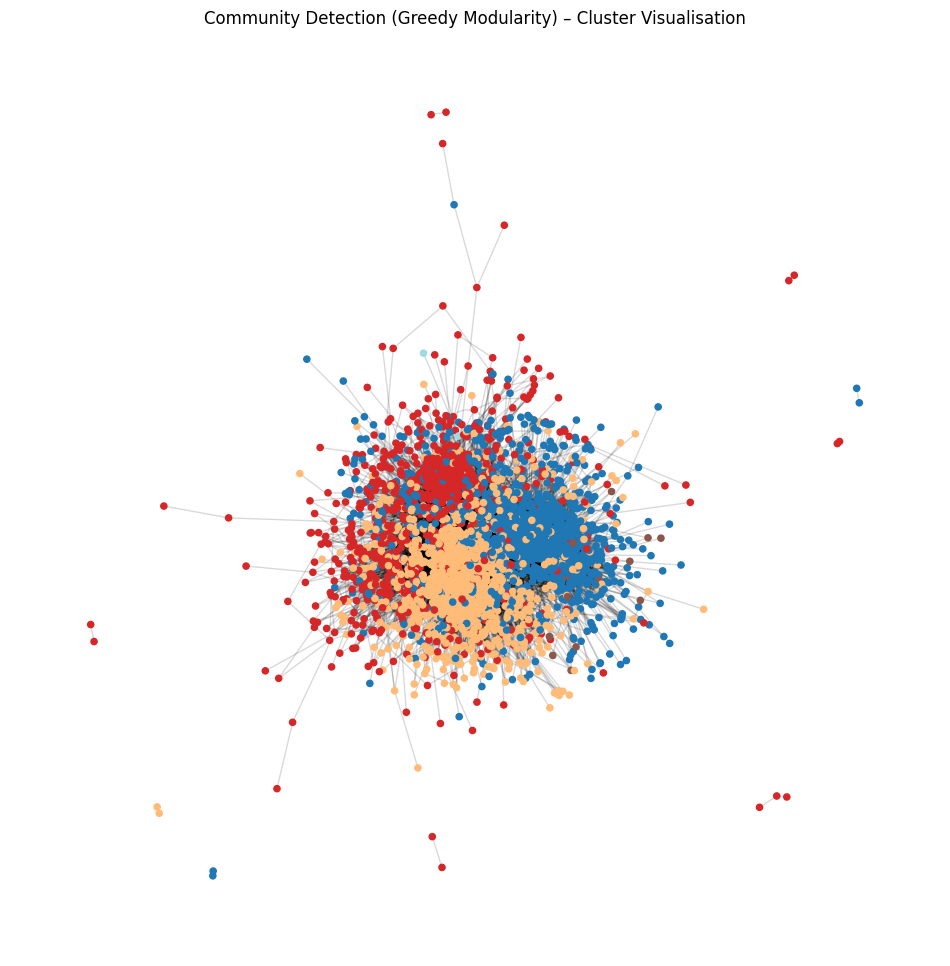

In [ ]:
# Keep only strong edges for plotting (visual clarity)
MIN_W_PLOT = 3

plot_edges = [(u, v) for u, v, d in UG_cd.edges(data=True) if d.get("weight", 0) >= MIN_W_PLOT]

# Random sample of edges
MAX_EDGES = 20000
if len(plot_edges) > MAX_EDGES:
    plot_edges = random.sample(plot_edges, MAX_EDGES)

# Subgraph used for visualisation
H = UG_cd.edge_subgraph(plot_edges).copy()

# Node colors
colors = [node_to_comm.get(n, -1) for n in H.nodes()]

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(H, k=0.4, seed=42)

nx.draw_networkx_nodes(H, pos, node_size=20, node_color=colors, cmap=plt.cm.tab20)
nx.draw_networkx_edges(H, pos, alpha=0.15)

plt.title("Community Detection (Greedy Modularity) – Cluster Visualisation")
plt.axis("off")
plt.show()


##  <font color=#bc5a45><b> D) 2. Community Analysis

Community size analysis reveals an imbalanced structure, with a small number of dominant communities containing most movies and a long tail of smaller communities, including many single-node clusters.  Large communities reflect broad similarity groupings driven by common genres and recurring cast members, while smaller and singleton communities represent structurally peripheral films with weak or specialised similarity links. The prevalence of singleton communities reflects the core-periphery nature of the network and the effect of edge-weight thresholding, which removes weak similarity connections. Overall, the network exhibits a modular structure with dense intra-community connectivity and sparse inter-community links.

In [ ]:
# Run community detection on the full graph
communities = greedy_modularity_communities(UG, weight='weight')

# Convert to list (each element is a set of nodes)
community_list = list(communities)

print("Number of communities detected:", len(community_list))

Number of communities detected: 191


In [ ]:
# Summary of community sizes
from collections import Counter
sizes = [len(c) for c in community_list]
print("Community Size Distribution:")
for i, size in enumerate(sizes):
    print(f"Community {i+1}: {size} movies")



Community Size Distribution:
Community 1: 1867 movies
Community 2: 1515 movies
Community 3: 1308 movies
Community 4: 26 movies
Community 5: 4 movies
Community 6: 3 movies
Community 7: 2 movies
Community 8: 1 movies
Community 9: 1 movies
Community 10: 1 movies
Community 11: 1 movies
Community 12: 1 movies
Community 13: 1 movies
Community 14: 1 movies
Community 15: 1 movies
Community 16: 1 movies
Community 17: 1 movies
Community 18: 1 movies
Community 19: 1 movies
Community 20: 1 movies
Community 21: 1 movies
Community 22: 1 movies
Community 23: 1 movies
Community 24: 1 movies
Community 25: 1 movies
Community 26: 1 movies
Community 27: 1 movies
Community 28: 1 movies
Community 29: 1 movies
Community 30: 1 movies
Community 31: 1 movies
Community 32: 1 movies
Community 33: 1 movies
Community 34: 1 movies
Community 35: 1 movies
Community 36: 1 movies
Community 37: 1 movies
Community 38: 1 movies
Community 39: 1 movies
Community 40: 1 movies
Community 41: 1 movies
Community 42: 1 movies
Comm

Inspection of representative movies from large communities confirms that clusters group films with overlapping genres and cast members.

In [ ]:
# Display example movies from the largest community
largest_comm = max(community_list, key=len)
example_movies = list(largest_comm)[:10]

print("Example movies from the largest community:")
print(", ".join(example_movies))


Example movies from the largest community:
The SpongeBob Movie: Sponge Out of Water, The New Guy, Beasts of the Southern Wild, A Turtle's Tale: Sammy's Adventures, Ghost Rider, Pokémon 3: The Movie, The 6th Day, Batman, Escape from Planet Earth, Ishtar


#  <font color=#bc5a45><b> E. Network Insights

##  <font color=#bc5a45><b>E) 1. Degree Structure and Directionality

The movie similarity network is a directed, weighted graph, where nodes represent movies and edges represent similarity based on shared actors and genres. Edge direction encodes temporal ordering from older to newer (with same-year films linked bidirectionally).

In this setting, out-degree reflects similarity to later movies while in-degree reflects similarity to earlier movies. The highly skewed degree distribution reflects widespread reuse of genres and cast members, indicating that degree centrality captures breadth of similarity across time rather than exclusivity, importance, or influence.  This highlights how temporal direction alters the interpretation of degree-based measures.

##  <font color=#bc5a45><b>E) 2. Edge Weights and Similarity Strength

Edges are weighted to represent similarity strength, defined as the number of shared actors and genres between two movies. Movies that share multiple actors and/or genres therefore form stronger connections than those sharing a single attribute.

This weighting introduces analytical structure into an otherwise dense network by distinguishing incidental similarity from stronger multi-feature relationships, even when similarity is traced across time.

As a result, weighted edges improve the interpretability of both centrality and community detection outcomes

##  <font color=#bc5a45><b>E) 3. Scale-Free Tendencies and Small-World Behaviour

The presence of movies with extremely high degree suggests hub-dominated behaviour, which is often associated with scale-free networks *(Barabási and Albert, 1999)*. However, the network does not follow a strict power-law degree distribution. The widespread reuse of broad genres and recurring cast members inflates connectivity across the graph, producing many high-degree nodes. Consequently, the network is not strictly scale-free and is better described as hub-dominated.

In contrast, the network does exhibit small-world characteristics *(Watts and Strogatz, 1998*). High clustering emerges from dense similarity links within genre and cast groupings, while the presence of a large weakly connected component ensures that most movies are reachable from one another through short paths. This reflects the real-world organisation of movie content, where films are linked through overlapping themes and actors across time.

##  <font color=#bc5a45><b>E) 4. Community Structure and Consequences of Similarity Design

Community detection identifies a small number of very large communities, particularly when edge weights are incorporated. These communities do not correspond to sharply separated genre categories but reflect overlapping similarity regions, where movies share partial attributes with many others across time. Smaller and singleton communities correspond to movies with rare combinations of genres or cast members, or to films whose similarity links are weak after thresholding.

This outcome highlights an important consequence of the similarity design. Because genres and actors are widely reused across the dataset, similarity relationships overlap extensively, encouraging community blending rather than sharp separation. The resulting communities are therefore loosely bounded, reflecting the inherently overlapping nature of movie similarity rather than a limitation of the community detection method.

##  <font color=#bc5a45><b>E) 5. Critical Reflection on Modelling Choices

The network was constructed using shared genres and cast members as the sole criteria for defining similarity, with edge weights representing the number of shared features between movie pairs. These attributes provide a clear and interpretable basis for content-based similarity, naturally producing a dense, hub-dominated network with overlapping communities and short path lengths due to widespread genre and actor reuse.

Additional attributes, including IMDb score, release year, country, director, and keywords, were deliberately excluded from edge construction, as they do not directly define pairwise similarity and would add limited structural insight while increasing network density. Instead, these attributes were incorporated at the recommendation stage to support preference-based filtering and ranking. (See E6)

This separation between structural similarity (genres and cast) and preference-based selection (metadata) reflects a realistic recommendation workflow. Overall, the modelling approach prioritises clarity, flexibility, and practical relevance, while acknowledging the dense and overlapping nature of movie similarity networks.

##  <font color=#bc5a45><b>E) 6. Practical application: network-driven film recommendation


Although modularity-based community detection produces a small number of large clusters due to dense and overlapping similarity links, the network remains well suited to neighbour-based recommendation. Recommendations are generated by ranking a seed movie's neighbours by edge weight, with metadata such as IMDb score, release year, and country applied for preference-based filtering. An undirected similarity graph is used for recommendation because similarity is symmetric, while edge direction is reserved for temporal analysis elsewhere in the report.

Pick a movie you like

In [ ]:
seed_movie = "The Host"
neighbors = UG[seed_movie]

# Sort by edge weight (strongest similarity first)
similar_movies = sorted(
    neighbors.items(),
    key=lambda x: x[1]['weight'],
    reverse=True
)

Get similar movies from the graph, movies most similar to 'The Host' based on cast and genre

In [ ]:
neighbors = UG[seed_movie]

# Sort by edge weight (strongest similarity first)
similar_movies = sorted(
    neighbors.items(),
    key=lambda x: x[1]['weight'],
    reverse=True
)

Use metadata to decide what to watch

Example A: Prefer high-rated movies - Filtering neighbours by IMDb score prioritises higher-quality recommendations within the same similarity neighbourhood

In [ ]:
recommendations = []

for movie, attrs in similar_movies:
    score = UG.nodes[movie]['imdb_score']
    if score and score >= 7.0:
        recommendations.append((movie, score, attrs['weight']))

# Sort by similarity weight first, then IMDb score
recommendations = sorted(
    recommendations,
    key=lambda x: (x[2], x[1]),  # (similarity weight, IMDb score)
    reverse=True
)

recommendations[:10]

[('Godzilla Resurgence', 8.2, 12),
 ('King Kong', 7.2, 12),
 ('The Avengers', 8.1, 8),
 ('The Return of the Living Dead', 7.3, 8),
 ('20,000 Leagues Under the Sea', 7.2, 8),
 ('The Dead Zone', 7.2, 7),
 ('Deadpool', 8.1, 6),
 ('Casino Royale', 8.0, 6),
 ('The Iron Giant', 8.0, 6),
 ('Big Hero 6', 7.9, 6)]

Example B: Prefer recent movies - Filtering by release year biases recommendations toward newer films while preserving similarity structure.

In [ ]:
recommendations = []

for movie, attrs in similar_movies:
    year = UG.nodes[movie]['year']
    if year and year >= 2010:
        recommendations.append((movie, year, attrs['weight']))

# Sort by similarity first, then newest year
recommendations = sorted(
    recommendations,
    key=lambda x: (x[2], x[1]),  # (similarity weight, year)
    reverse=True
)

recommendations[:10]

[('Victor Frankenstein', 2015.0, 15),
 ('Godzilla Resurgence', 2016.0, 12),
 ('Home', 2015.0, 12),
 ('The Lovers', 2015.0, 10),
 ('Teenage Mutant Ninja Turtles', 2014.0, 10),
 ('The Legend of Tarzan', 2016.0, 8),
 ('Ghostbusters', 2016.0, 8),
 ('Fantastic Four', 2015.0, 8),
 ('RoboCop', 2014.0, 8),
 ('The Avengers', 2012.0, 8)]

Example C: Prefer movies from the same country - Country filtering can be overly restrictive in this dataset and may return few results depending on the seed movie.

In [ ]:
seed_country = UG.nodes[seed_movie]['country']

recommendations = []

for movie, attrs in similar_movies:
    if UG.nodes[movie]['country'] == seed_country:
        recommendations.append((movie, attrs['weight']))

recommendations[:10]

[('Snowpiercer', 6),
 ('The Good, the Bad, the Weird', 4),
 ('Dragon Wars: D-War', 4),
 ('Tidal Wave', 4)]

Example D: Combine everything

In [ ]:
final_recs = []

for movie, attrs in similar_movies:
    score = UG.nodes[movie]['imdb_score']
    year = UG.nodes[movie]['year']
    country = UG.nodes[movie]['country']

    if score and year and score >= 7.0 and year >= 2010:
        final_recs.append({
            "movie": movie,
            "similarity": attrs['weight'],
            "rating": score,
            "year": year,
            "country": country
        })

# Sort by:
# 1) similarity (desc)
# 2) IMDb score (desc)
# 3) year (desc)
# 4) country (asc, alphabetical)
final_recs = sorted(
    final_recs,
    key=lambda x: (
        x['similarity'],
        x['rating'],
        x['year'],
        x['country'] if x['country'] else ""
    ),
    reverse=True
)

final_recs[:10]

for rec in final_recs[:10]:
    print(
        f"{rec['movie']} | "
        f"Similarity: {rec['similarity']} | "
        f"IMDb: {rec['rating']} | "
        f"Year: {rec['year']} | "
        f"Country: {rec['country']}"
    )

Godzilla Resurgence | Similarity: 12 | IMDb: 8.2 | Year: 2016.0 | Country: Japan
The Avengers | Similarity: 8 | IMDb: 8.1 | Year: 2012.0 | Country: USA
Deadpool | Similarity: 6 | IMDb: 8.1 | Year: 2016.0 | Country: USA
Big Hero 6 | Similarity: 6 | IMDb: 7.9 | Year: 2014.0 | Country: USA
Skyfall | Similarity: 6 | IMDb: 7.8 | Year: 2012.0 | Country: UK
Dredd | Similarity: 6 | IMDb: 7.1 | Year: 2012.0 | Country: UK
World War Z | Similarity: 6 | IMDb: 7.0 | Year: 2013.0 | Country: USA
Snowpiercer | Similarity: 6 | IMDb: 7.0 | Year: 2013.0 | Country: South Korea
Inception | Similarity: 5 | IMDb: 8.8 | Year: 2010.0 | Country: USA
Mad Max: Fury Road | Similarity: 5 | IMDb: 8.1 | Year: 2015.0 | Country: Australia


#  <font color=#bc5a45><b> F. Citations

Barabási, A.-L. (2016) Network Science. Cambridge: Cambridge University Press. Available at: https://networksciencebook.com/

Barabási, A.-L. and Albert, R. (1999) 'Emergence of scaling in random networks', Science, 286(5439), pp. 509-512. https://doi.org/10.1126/science.286.5439.509

Brandes, U. (2001) 'A faster algorithm for betweenness centrality', Journal of Mathematical Sociology, 25(2), pp. 163-177. https://doi.org/10.1080/0022250X.2001.9990249

Clauset, A., Newman, M. E. J. and Moore, C. (2004) 'Finding community structure in very large networks', Physical Review E, 70(6), 066111. https://doi.org/10.1103/PhysRevE.70.066111

Freeman, L. C. (1978) 'Centrality in social networks: Conceptual clarification', Social Networks, 1(3), pp. 215-239. https://doi.org/10.1016/0378-8733(78)90021-7

Hagberg, A., Schult, D. and Swart, P. (2008) 'Exploring network structure, dynamics, and function using NetworkX', in Proceedings of the 7th Python in Science Conference (SciPy 2008). Pasadena, CA, pp. 11-15.

Newman, M. E. J. (2006) 'Modularity and community structure in networks', Proceedings of the National Academy of Sciences, 103(23), pp. 8577-8582. https://doi.org/10.1073/pnas.0601602103

Newman, M. E. J. (2010) Networks: An Introduction. Oxford: Oxford University Press.

Virtanen, P. et al. (2020) 'SciPy 1.0: Fundamental algorithms for scientific computing in Python', Nature Methods, 17, pp. 261-272. https://doi.org/10.1038/s41592-019-0686-2

Watts, D. J. and Strogatz, S. H. (1998) -‘Collective dynamics of “small-world” networks-, Nature, 393, pp. 440-442. https://doi.org/10.1038/30918

Zhang, C. (2016) IMDb 5000 Movie Dataset. Kaggle. Available at: https://www.kaggle.com/datasets/carolzhangdc/imdb-5000-movie-dataset
